# Project 7 - Transformer-based Recommendation System

In this project, I create a transformer-based recommendation system. To train the model, I'll use the [1M MovieLens Dataset](https://grouplens.org/datasets/movielens/1m/). Released in February 2023, it's the most recently relased MovieLens dataset available from GroupLens.

Note: A large part of this notebook is based on the Keras code example, [A Transformer-based recommendation system](https://keras.io/examples/structured_data/movielens_recommendations_transformers/)

## Notebook Preparation

Import libraries.

In [ ]:
import os
import random
import math
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from collections import Counter
from tabulate import tabulate

Set seeds for reproducibility.

In [ ]:
os.environ['PYTHONHASHSEED']='7'
random.seed(7)
np.random.seed(7)
tf.random.set_seed(7)
tf.keras.utils.set_random_seed(7)

## Data Preparation

I ran into errors regarding the encoding of the file while loading the data into memory, so I determined the encoding then specified it while loading the data.

In [ ]:
import chardet
file_path = "/content/drive/MyDrive/Colab Notebooks/DSCI619/Project 7/ml-1m/movies.dat"
with open(file_path, 'rb') as f:
    raw_data = f.read(10000)
result = chardet.detect(raw_data)
encoding = result['encoding']
print("Detected Encoding:", encoding)

Detected Encoding: ISO-8859-1


Load the data into memory.

In [ ]:
users_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/DSCI619/Project 7/ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
    engine='python')

ratings_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/DSCI619/Project 7/ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
    engine='python')

movies_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/DSCI619/Project 7/ml-1m/movies.dat",
    sep="::",
    names=["movie_id", "title", "genres"],
    engine='python',
    encoding='ISO-8859-1')

Fix the data types of the columns.

In [ ]:
users_df["user_id"] = users_df["user_id"].apply(lambda x: f"user_{x}")
users_df["age_group"] = users_df["age_group"].apply(lambda x: f"group_{x}")
users_df["occupation"] = users_df["occupation"].apply(lambda x: f"occupation_{x}")

ratings_df["movie_id"] = ratings_df["movie_id"].apply(lambda x: f"movie_{x}")
ratings_df["user_id"] = ratings_df["user_id"].apply(lambda x: f"user_{x}")
ratings_df["rating"] = ratings_df["rating"].apply(lambda x: float(x))

movies_df["movie_id"] = movies_df["movie_id"].apply(lambda x: f"movie_{x}")

View the `movies_df` dataset.

In [ ]:
movies_df.head()

,movie_id,title,genres
0,movie_1,Toy Story (1995),Animation|Children's|Comedy
1,movie_2,Jumanji (1995),Adventure|Children's|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama
4,movie_5,Father of the Bride Part II (1995),Comedy


Each movie has multiple genres, which need to be split into separate columns.

In [ ]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western"]

for genre in genres:
    movies_df[genre] = movies_df["genres"].apply(
        lambda values: int(genre in values.split("|")))

### Describe the data.

In [ ]:
users_df.describe()

,user_id,sex,age_group,occupation,zip_code
count,6040,6040,6040,6040,6040
unique,6040,2,7,21,3439
top,user_1,M,group_25,occupation_4,48104
freq,1,4331,2096,759,19


In [ ]:
ratings_df.describe()

,rating,unix_timestamp
count,1.000209e+06,1.000209e+06
mean,3.581564e+00,9.722437e+08
std,1.117102e+00,1.215256e+07
min,1.000000e+00,9.567039e+08
25%,3.000000e+00,9.653026e+08
50%,4.000000e+00,9.730180e+08
75%,4.000000e+00,9.752209e+08
max,5.000000e+00,1.046455e+09


In [ ]:
movies_df.describe()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,0.129539,0.072882,0.027041,0.064641,0.309039,0.054339,0.032707,0.412825,0.017512,0.011331,0.088334,0.029359,0.027298,0.121298,0.071079,0.126706,0.036827,0.017512
std,0.335839,0.259976,0.162224,0.245923,0.462157,0.226715,0.177891,0.492405,0.131187,0.105858,0.283816,0.168832,0.162973,0.326515,0.256990,0.332686,0.188362,0.131187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Check for missing values in the dataset.

In [ ]:
users_df.isnull().sum()/len(users_df)*100

user_id       0.0
sex           0.0
age_group     0.0
occupation    0.0
zip_code      0.0
dtype: float64

In [ ]:
ratings_df.isnull().sum()/len(ratings_df)*100

user_id           0.0
movie_id          0.0
rating            0.0
unix_timestamp    0.0
dtype: float64

In [ ]:
movies_df.isnull().sum()/len(movies_df)*100

movie_id       0.0
title          0.0
genres         0.0
Action         0.0
Adventure      0.0
Animation      0.0
Children's     0.0
Comedy         0.0
Crime          0.0
Documentary    0.0
Drama          0.0
Fantasy        0.0
Film-Noir      0.0
Horror         0.0
Musical        0.0
Mystery        0.0
Romance        0.0
Sci-Fi         0.0
Thriller       0.0
War            0.0
Western        0.0
dtype: float64

In [ ]:
ratings_df["movie_id"].unique()[:20]

array(['movie_1193', 'movie_661', 'movie_914', 'movie_3408', 'movie_2355',
       'movie_1197', 'movie_1287', 'movie_2804', 'movie_594', 'movie_919',
       'movie_595', 'movie_938', 'movie_2398', 'movie_2918', 'movie_1035',
       'movie_2791', 'movie_2687', 'movie_2018', 'movie_3105',
       'movie_2797'], dtype=object)

In [ ]:
ratings_df["user_id"].unique()[:20]

array(['user_1', 'user_2', 'user_3', 'user_4', 'user_5', 'user_6',
       'user_7', 'user_8', 'user_9', 'user_10', 'user_11', 'user_12',
       'user_13', 'user_14', 'user_15', 'user_16', 'user_17', 'user_18',
       'user_19', 'user_20'], dtype=object)

In [ ]:
user_ids = ratings_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = ratings_df["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
ratings_df["user"] = ratings_df["user_id"].map(user2user_encoded)
ratings_df["movie"] = ratings_df["movie_id"].map(movie2movie_encoded)
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
unique_rating = ratings_df["rating"].unique().tolist()
ratings_df["rating"] = ratings_df["rating"].values.astype(np.float32)

In [ ]:
print("Number of users:", num_users)
print("Number of Movies:", num_movies)
print("The unique rating values:", sorted(unique_rating))

Number of users: 6040
Number of Movies: 3706
The unique rating values: [1.0, 2.0, 3.0, 4.0, 5.0]


Visualize the data.

<Axes: xlabel='rating', ylabel='count'>

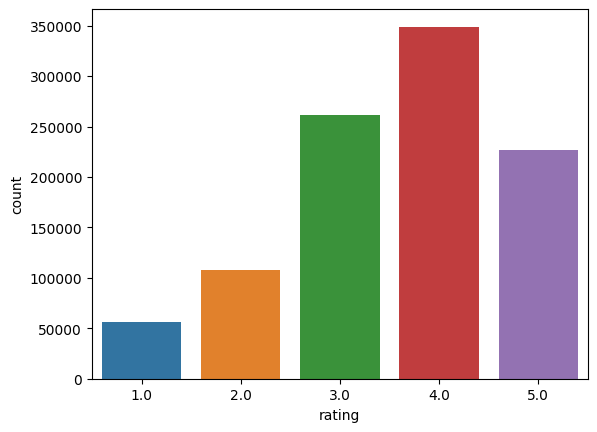

In [ ]:
sns.countplot(x='rating',
              data=ratings_df)

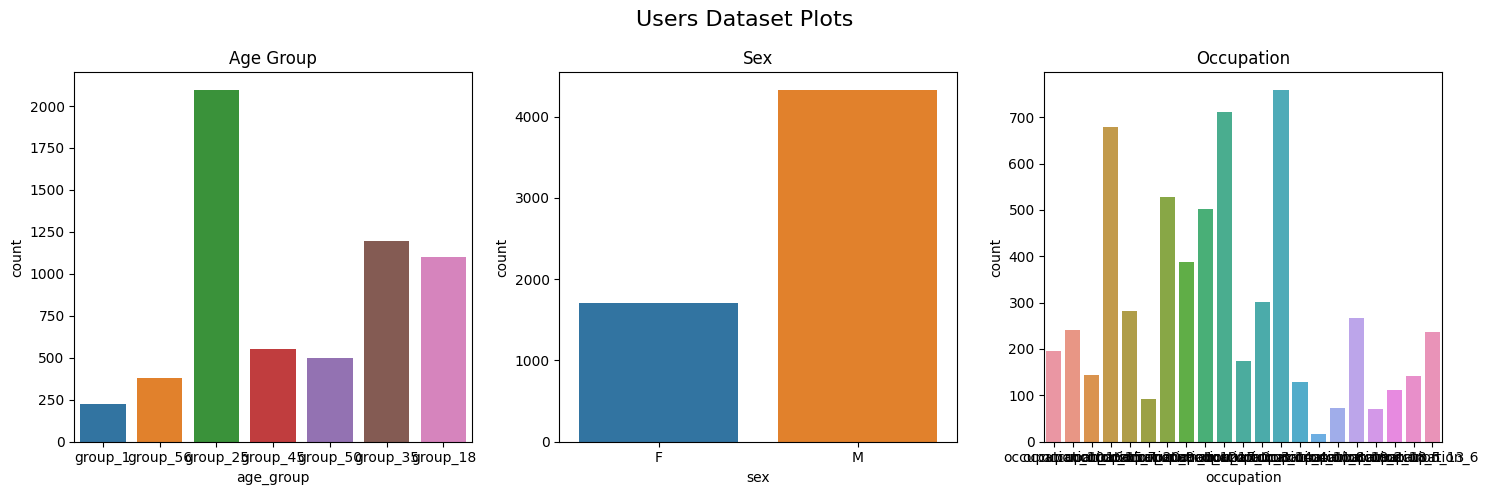

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(x='age_group', data=users_df, ax=axes[0])
axes[0].set_title('Age Group')
sns.countplot(x='sex', data=users_df, ax=axes[1])
axes[1].set_title('Sex')
sns.countplot(x='occupation', data=users_df, ax=axes[2])
axes[2].set_title('Occupation')
plt.suptitle("Users Dataset Plots", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
result = ratings_df.groupby('user').agg({'rating': ['mean', 'min', 'max']})
result

rating          
          mean  min  max
user                    
0     4.188679  3.0  5.0
1     3.713178  1.0  5.0
2     3.901961  1.0  5.0
3     4.190476  1.0  5.0
4     3.146465  1.0  5.0
...        ...  ...  ...
6035  3.302928  1.0  5.0
6036  3.717822  1.0  5.0
6037  3.800000  1.0  5.0
6038  3.878049  2.0  5.0
6039  3.577713  1.0  5.0

[6040 rows x 3 columns]

In [ ]:
result = ratings_df.groupby('movie').agg({'rating': ['mean', 'min', 'max']})
result

rating          
           mean  min  max
movie                    
0      4.390725  1.0  5.0
1      3.464762  1.0  5.0
2      4.154088  1.0  5.0
3      3.863878  1.0  5.0
4      3.854375  1.0  5.0
...         ...  ...  ...
3701   4.000000  3.0  5.0
3702   3.000000  3.0  3.0
3703   1.000000  1.0  1.0
3704   5.000000  5.0  5.0
3705   4.000000  4.0  4.0

[3706 rows x 3 columns]

In [ ]:
result = ratings_df.groupby(['user', 'movie']).agg({'rating': ['mean', 'min', 'max']})
result

rating          
             mean  min  max
user movie                 
0    0        5.0  5.0  5.0
     1        3.0  3.0  3.0
     2        3.0  3.0  3.0
     3        4.0  4.0  4.0
     4        5.0  5.0  5.0
...           ...  ...  ...
6039 2911     5.0  5.0  5.0
     2955     1.0  1.0  1.0
     3042     5.0  5.0  5.0
     3046     3.0  3.0  3.0
     3412     5.0  5.0  5.0

[1000209 rows x 3 columns]

## Model Development

### Transform the movie ratings data into sequences.

Sort the ratings data and group the `movie_id` by `rating` and `user_id`.

In [ ]:
ratings_group = ratings_df.sort_values(by=["unix_timestamp"]).groupby("user_id")

ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "ratings": list(ratings_group.rating.apply(list)),
        "timestamps": list(ratings_group.unix_timestamp.apply(list))})

Split the `movie_ids` and `ratings` into fixed-length sequences. Set the `sequence_length` variable to change the model's input sequence length.

In [ ]:
sequence_length = 4
step_size = 2

def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences

ratings_data.movie_ids = ratings_data.movie_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size))

ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size))

del ratings_data["timestamps"]

Process each sequence into separate records and join the user features with the ratings data.

In [ ]:
ratings_data_movies = ratings_data[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True)
ratings_data_rating = ratings_data[["ratings"]].explode("ratings",
                                                        ignore_index=True)
ratings_data_transformed = pd.concat([ratings_data_movies,
                                      ratings_data_rating],
                                     axis=1)
ratings_data_transformed = ratings_data_transformed.join(
    users_df.set_index("user_id"), on="user_id")
ratings_data_transformed.movie_ids = ratings_data_transformed.movie_ids.apply(
    lambda x: ",".join(x))
ratings_data_transformed.ratings = ratings_data_transformed.ratings.apply(
    lambda x: ",".join([str(v) for v in x]))

del ratings_data_transformed["zip_code"]

ratings_data_transformed.rename(
    columns={"movie_ids": "sequence_movie_ids",
             "ratings": "sequence_ratings"},
    inplace=True)

Finally split the data into training and test splits and store them in CSV files.



In [ ]:
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.80
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
test_data.to_csv("test_data.csv", index=False, sep="|", header=False)

### Define metadata

In [ ]:
CSV_HEADER = list(ratings_data_transformed.columns)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(users_df.user_id.unique()),
    "movie_id": list(movies_df.movie_id.unique()),
    "sex": list(users_df.sex.unique()),
    "age_group": list(users_df.age_group.unique()),
    "occupation": list(users_df.occupation.unique())}

USER_FEATURES = ["sex", "age_group", "occupation"]

MOVIE_FEATURES = ["genres"]

### Create `tf.data.Dataset` for training and evaluation

In [ ]:
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    def process(features):
        movie_ids_string = features["sequence_movie_ids"]
        sequence_movie_ids = tf.strings.split(movie_ids_string, ",").to_tensor()
        features["target_movie_id"] = sequence_movie_ids[:, -1]
        features["sequence_movie_ids"] = sequence_movie_ids[:, :-1]
        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]
        return features, target

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    ).map(process)

    return dataset

### Create model inputs

In [ ]:
def create_model_inputs():
    return {
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        "sequence_movie_ids": layers.Input(
            name="sequence_movie_ids",
            shape=(sequence_length - 1,),
            dtype=tf.string),
        "target_movie_id": layers.Input(
            name="target_movie_id",
            shape=(1,),
            dtype=tf.string),
        "sequence_ratings": layers.Input(
            name="sequence_ratings",
            shape=(sequence_length - 1,),
            dtype=tf.float32),
        "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
    }

### Encode input features

The `encode_input_features` method works as follows:

1. Each categorical user feature is encoded using `layers.Embedding`, with embedding dimension equals to the square root of the vocabulary size of the feature. The embeddings of these features are concatenated to form a single input tensor.

2. Each movie in the movie sequence and the target movie is encoded `layers.Embedding`, where the dimension size is the square root of the number of movies.

3. A multi-hot genres vector for each movie is concatenated with its embedding vector, and processed using a non-linear `layers.Dense` to output a vector of the same movie embedding dimensions.

4. A positional embedding is added to each movie embedding in the sequence, and then multiplied by its rating from the ratings sequence.

5. The target movie embedding is concatenated to the sequence movie embeddings, producing a tensor with the shape of `[batch size, sequence length, embedding size]`, as expected by the attention layer for the transformer architecture.

6. The method returns a tuple of two elements: `encoded_transformer_features` and encoded_other_features.

In [ ]:
def encode_input_features(
    inputs,
    include_user_id=True,
    include_user_features=True,
    include_movie_features=True):
    encoded_transformer_features = []
    encoded_other_features = []
    other_feature_names = []
    if include_user_id:
        other_feature_names.append("user_id")
    if include_user_features:
        other_feature_names.extend(USER_FEATURES)
    for feature_name in other_feature_names:
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary,
                           mask_token=None,
                           num_oov_indices=0)(inputs[feature_name])
        embedding_dims = int(math.sqrt(len(vocabulary)))
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",)
        encoded_other_features.append(embedding_encoder(idx))
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None
    movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["movie_id"]
    movie_embedding_dims = int(math.sqrt(len(movie_vocabulary)))
    movie_index_lookup = StringLookup(
        vocabulary=movie_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="movie_index_lookup")
    movie_embedding_encoder = layers.Embedding(
        input_dim=len(movie_vocabulary),
        output_dim=movie_embedding_dims,
        name=f"movie_embedding",)
    genre_vectors = movies_df[genres].to_numpy()
    movie_genres_lookup = layers.Embedding(
        input_dim=genre_vectors.shape[0],
        output_dim=genre_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(genre_vectors),
        trainable=False,
        name="genres_vector",)
    movie_embedding_processor = layers.Dense(
        units=movie_embedding_dims,
        activation="relu",
        name="process_movie_embedding_with_genres",)

    def encode_movie(movie_id):
        movie_idx = movie_index_lookup(movie_id)
        movie_embedding = movie_embedding_encoder(movie_idx)
        encoded_movie = movie_embedding
        if include_movie_features:
            movie_genres_vector = movie_genres_lookup(movie_idx)
            encoded_movie = movie_embedding_processor(
                layers.concatenate([movie_embedding, movie_genres_vector]))
        return encoded_movie

    target_movie_id = inputs["target_movie_id"]
    encoded_target_movie = encode_movie(target_movie_id)
    sequence_movies_ids = inputs["sequence_movie_ids"]
    encoded_sequence_movies = encode_movie(sequence_movies_ids)
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length,
        output_dim=movie_embedding_dims,
        name="position_embedding")
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    sequence_ratings = tf.expand_dims(inputs["sequence_ratings"], -1)
    encoded_sequence_movies_with_poistion_and_rating = layers.Multiply()(
        [(encoded_sequence_movies + encodded_positions), sequence_ratings])

    for encoded_movie in tf.unstack(
        encoded_sequence_movies_with_poistion_and_rating, axis=1):
        encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1))
    encoded_transformer_features.append(encoded_target_movie)

    encoded_transformer_features = layers.concatenate(
        encoded_transformer_features, axis=1)

    return encoded_transformer_features, encoded_other_features

### Create a BST model

In [ ]:
include_user_id = False
include_user_features = False
include_movie_features = False

hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3

def create_model():
    inputs = create_model_inputs()
    transformer_features, other_features = encode_input_features(
        inputs, include_user_id, include_user_features, include_movie_features)
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=transformer_features.shape[2],
        dropout=dropout_rate
    )(transformer_features, transformer_features)

    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x1 = layers.Add()([transformer_features, attention_output])
    x1 = layers.LayerNormalization()(x1)
    x2 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x2.shape[-1])(x2)
    x2 = layers.Dropout(dropout_rate)(x2)
    transformer_features = layers.Add()([x1, x2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)

    if other_features is not None:
        features = layers.concatenate(
            [features,
             layers.Reshape([other_features.shape[-1]])(other_features)])

    for num_units in hidden_units:
        features = layers.Dense(num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model()

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


### Run training and evaluation experiment.

Initialize early stopping callback.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    mode='min')

Compile the model with metrics.

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError(),
             keras.metrics.MeanAbsoluteError()])

Read the training and test data.

In [ ]:
train_dataset = get_dataset_from_csv("train_data.csv",
                                     shuffle=True,
                                     batch_size=128)
test_dataset = get_dataset_from_csv("test_data.csv",
                                    batch_size=128)

Fit the model with the training data.

In [ ]:
history = model.fit(
    train_dataset,
    batch_size=128,
    #epochs=100,
    epochs=3,
    verbose=1,
    validation_data=(test_dataset),
    callbacks=[early_stopping])

Epoch 1/3
3114/3114 [==============================] - 77s 24ms/step - loss: 1.1704 - mean_squared_error: 1.1704 - mean_absolute_error: 0.8555 - val_loss: 0.9244 - val_mean_squared_error: 0.9244 - val_mean_absolute_error: 0.7716
Epoch 2/3
3114/3114 [==============================] - 71s 23ms/step - loss: 0.9403 - mean_squared_error: 0.9403 - mean_absolute_error: 0.7731 - val_loss: 0.9677 - val_mean_squared_error: 0.9677 - val_mean_absolute_error: 0.7975
Epoch 3/3
3114/3114 [==============================] - 71s 23ms/step - loss: 0.8993 - mean_squared_error: 0.8993 - mean_absolute_error: 0.7551 - val_loss: 0.9048 - val_mean_squared_error: 0.9048 - val_mean_absolute_error: 0.7536


Evaluate the model on the test data.

In [ ]:
loss, mse, mae = model.evaluate(test_dataset, verbose=1)
results = [["Test Loss", loss], ["Test MSE", mse], ["Test MAE", mae]]
print(tabulate(results, headers=["Metric", "Value"], tablefmt="grid"))

782/782 [==============================] - 6s 8ms/step - loss: 0.9048 - mean_squared_error: 0.9048 - mean_absolute_error: 0.7536
+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Test Loss | 0.904825 |
+-----------+----------+
| Test MSE  | 0.904825 |
+-----------+----------+
| Test MAE  | 0.753571 |
+-----------+----------+


Summarize the model.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_movie_ids (InputLayer  [(None, 3)]         0           []                               
 )                                                                                                
                                                                                                  
 movie_index_lookup (StringLook  multiple            0           ['target_movie_id[0][0]',        
 up)                                                              'sequence_movie_ids[0][0]']     
                                                                                                  
 movie_embedding (Embedding)    multiple             240746      ['movie_index_lookup[0][0]',     
                                                                  'movie_index_lookup[1][0]'] 

Evaluate sample fit.

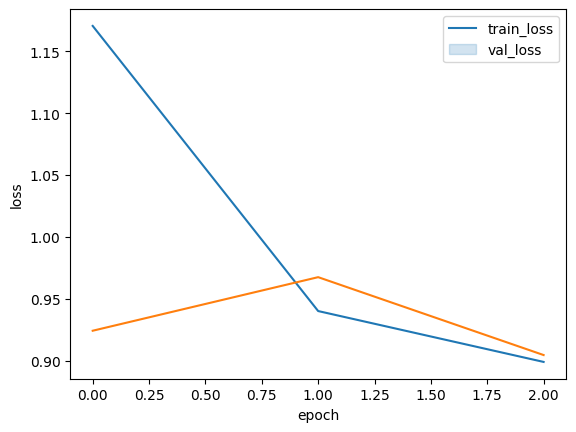

In [ ]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])
plt.show()

In [ ]:
model.save(filepath='/content/drive/MyDrive/Colab Notebooks/DSCI619/Project 7/model-save')

## Recommend the Movies

Above, we've built, trained, and evaluated a BST recommender model, as required by the assignment. However, I wanted to try to take it a step further and get it to spit out some recommendations.

In [ ]:
test_users = test_data["user_id"].unique()
user_id = np.random.choice(test_users, size=1)[0]
print("Recommendations for User:", user_id)
predicted_ratings = model.predict((test_dataset))
predicted_ratings = predicted_ratings[0]
movie_ids = np.array(movie_ids)
predicted_ratings = np.squeeze(predicted_ratings)
top_ratings_indices = predicted_ratings.argsort()[-10:][::-1]
recommended_movie_ids = [movie_ids[i] for i in top_ratings_indices]
print("Top 10 Highest-Rated Movies")
print("\n")
top_movies = ratings_df.loc[ratings_df["user_id"] == user_id].sort_values("rating",ascending=False).head(10)[["movie_id","rating"]]
top_movies = top_movies.join(movies_df.set_index("movie_id"), on="movie_id")[["title","genres"]]
print(tabulate(top_movies, headers=["Title", "Genres"], tablefmt="grid"))
print("\n")
print("Top 10 Movie Recommendations")
print("\n")
recommendations = movies_df[movies_df["movie_id"].isin(recommended_movie_ids)][["title","genres"]]
print(tabulate(recommendations, headers=["Title", "Genres"], tablefmt="grid"))

Recommendations for User: user_584
782/782 [==============================] - 8s 10ms/step
Top 10 Highest-Rated Movies


+-------+-------------------------------------------+------------------------------------+
|       | Title                                     | Genres                             |
+=======+===========================================+====================================+
| 88439 | Star Wars: Episode IV - A New Hope (1977) | Action|Adventure|Fantasy|Sci-Fi    |
+-------+-------------------------------------------+------------------------------------+
| 88461 | Secrets & Lies (1996)                     | Drama                              |
+-------+-------------------------------------------+------------------------------------+
| 88449 | Jerry Maguire (1996)                      | Drama|Romance                      |
+-------+-------------------------------------------+------------------------------------+
| 88445 | In the Name of the Father (1993)          | Drama 

This code has given me much trouble. As you can see above, I've only been able to output one movie recommendation instead of the expected 10. Other attempts failed to output any recommendations, output non-human-readable text, or error out completely. Future research should rebuild the code with the intentions of outputting recommendations. After that, I would recommend testing this in a development environment in which the dataset evolves over time and the model must reconsider new data as it arrives.